In [1]:
!pip install tensorflow pandas numpy scikit-learn tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import gradio as gr
import pandas as pd




In [3]:
CSV_PATH = "https://raw.githubusercontent.com/Esteban0119/Prediccionpenaltis/refs/heads/main/penaltis.csv"

In [4]:
RANGES = {
    "Velocidad_kmh": (70, 115),
    "Angulo_grados": (5, 45),
    "Distancia_Portero_m": (0.4, 1.2)
}

In [5]:
df = pd.read_csv(CSV_PATH)
df.head()

,ID,Jugador,Velocidad_kmh,Angulo_grados,Distancia_Portero_m,Presion_Partido,Pie_Dominante,Gol (Target)
0,1,A. G.,95,25,0.8,Alta,Derecho,1
1,2,L. M.,78,10,0.5,Media,Izquierdo,0
2,3,C. R.,110,35,1.0,Alta,Derecho,1
3,4,K. B.,88,5,0.7,Baja,Derecho,0
4,5,T. H.,102,40,0.9,Media,Izquierdo,1


In [6]:
feature_numeric = ["Velocidad_kmh", "Angulo_grados", "Distancia_Portero_m"]
feature_cat = []
for c in ["Presion_Partido", "Pie_Dominante"]:
    if c in df.columns:
        feature_cat.append(c)

# Target: 'Gol (Target)' -> lo convertimos a 0/1 y a etiquetas para mostrar
target_col = "Gol (Target)"
if df[target_col].dtype != int and df[target_col].dtype != float:
    # si viene como 'Gol'/'Fallado', convertimos
    df[target_col] = df[target_col].map({"Gol":1, "Fallado":0})

# Drop ID/Jugador si existen
df_proc = df.copy()
for c in ["ID", "Jugador"]:
    if c in df_proc.columns:
        df_proc = df_proc.drop(columns=[c])

# One-hot para categóricas
df_dummies = pd.get_dummies(df_proc[feature_cat], drop_first=False) if feature_cat else pd.DataFrame(index=df_proc.index)
# Concatenar numéricos + dummies
X_raw = pd.concat([df_proc[feature_numeric].reset_index(drop=True), df_dummies.reset_index(drop=True)], axis=1)
y_raw = df_proc[target_col].astype(int).values

print("\nColumnas finales usadas para el modelo:")
print(list(X_raw.columns))


Columnas finales usadas para el modelo:
['Velocidad_kmh', 'Angulo_grados', 'Distancia_Portero_m', 'Presion_Partido_Alta', 'Presion_Partido_Baja', 'Presion_Partido_Media', 'Pie_Dominante_Derecho', 'Pie_Dominante_Izquierdo']


In [7]:
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_raw[feature_numeric])
X_scaled = np.concatenate([X_num_scaled, X_raw.drop(columns=feature_numeric).values], axis=1)

# Guardar columnas de entrenamiento para alinear en la predicción
feature_columns = list(X_raw.columns)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_raw, test_size=0.2, random_state=42, stratify=y_raw)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

<Figure size 500x400 with 0 Axes>

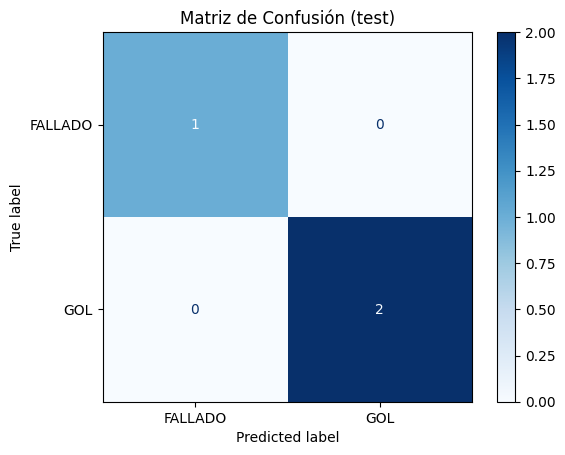

Accuracy en test: 100.00%
Confusion matrix (rows=real, cols=pred):
[[1 0]
 [0 2]]


In [9]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FALLADO","GOL"])
plt.figure(figsize=(5,4))
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión (test)")
plt.show()

# Mostrar reporte sencillo
acc = (y_test == y_pred).mean()
print(f"Accuracy en test: {acc*100:.2f}%")
print("Confusion matrix (rows=real, cols=pred):")
print(cm)

def build_feature_vector(f_vel, f_ang, f_dist, presion_val=None, pie_val=None):
    # Validaciones numéricas (antes de llamar a esta función ya validamos)
    # Crear df con una fila para luego one-hot y reindex
    row_num = {
        "Velocidad_kmh": float(f_vel),
        "Angulo_grados": float(f_ang),
        "Distancia_Portero_m": float(f_dist)
    }
    row_cat = {}
    if "Presion_Partido" in feature_cat:
        row_cat["Presion_Partido"] = presion_val
    if "Pie_Dominante" in feature_cat:
        row_cat["Pie_Dominante"] = pie_val

    df_row_num = pd.DataFrame([row_num])
    df_row_cat = pd.DataFrame([row_cat]) if row_cat else pd.DataFrame(index=[0])
    df_row_all = pd.concat([df_row_num, pd.get_dummies(df_row_cat, drop_first=False)], axis=1)

    # Ensure all columns present: add missing dummy columns with 0
    for col in feature_columns:
        if col not in df_row_all.columns:
            df_row_all[col] = 0.0

    # Reorder to match training
    df_row_all = df_row_all[feature_columns]

    # Scale numeric cols using fitted scaler
    df_row_all[feature_numeric] = (df_row_all[feature_numeric] - scaler.mean_) / scaler.scale_

    return df_row_all.values.astype(float)


In [10]:
def predecir_penalti(velocidad, angulo, distancia, presion="Media", pie="Derecho"):
    # Validaciones numéricas: si fuera de rango NO predecir
    checks = [
        ("Velocidad_kmh", velocidad),
        ("Angulo_grados", angulo),
        ("Distancia_Portero_m", distancia)
    ]
    for name, val in checks:
        min_v, max_v = RANGES[name]
        try:
            valf = float(val)
        except:
            return f"⚠️ El valor ingresado para {name} no es numérico."
        if valf < min_v or valf > max_v:
            return f"⚠️ El valor ingresado en {name} está fuera del rango permitido ({min_v} – {max_v}). No se puede realizar la predicción."

    # Construir vector y predecir
    x_vec = build_feature_vector(velocidad, angulo, distancia, presion, pie)
    prob = model.predict_proba(x_vec)[0][1]  # prob de clase 1 (Gol)
    pred_label = "GOL" if prob >= 0.5 else "FALLADO"
    return f"Probabilidad de GOL: {prob:.3f} → {pred_label}"


In [11]:
presion_vals = sorted(df["Presion_Partido"].dropna().unique().tolist()) if "Presion_Partido" in df.columns else []
pie_vals = sorted(df["Pie_Dominante"].dropna().unique().tolist()) if "Pie_Dominante" in df.columns else []

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## ⚽ Predicción de Penaltis (modelo real con tu dataset)")
    gr.Markdown("**Nota:** Si pones un valor fuera del rango permitido, **no** se realizará la predicción. Se mostrará un mensaje indicando el campo fuera de rango.")
    with gr.Row():
        velocidad_in = gr.Number(label=f"Velocidad_kmh (rango {RANGES['Velocidad_kmh'][0]}–{RANGES['Velocidad_kmh'][1]})", value=90)
        angulo_in = gr.Number(label=f"Angulo_grados (rango {RANGES['Angulo_grados'][0]}–{RANGES['Angulo_grados'][1]})", value=25)
        distancia_in = gr.Number(label=f"Distancia_Portero_m (rango {RANGES['Distancia_Portero_m'][0]}–{RANGES['Distancia_Portero_m'][1]})", value=0.8)
    with gr.Row():
        if presion_vals:
            presion_in = gr.Dropdown(choices=presion_vals, value=presion_vals[0], label="Presion_Partido")
        else:
            presion_in = gr.Textbox(value="Media", label="Presion_Partido")
        if pie_vals:
            pie_in = gr.Dropdown(choices=pie_vals, value=pie_vals[0], label="Pie_Dominante")
        else:
            pie_in = gr.Textbox(value="Derecho", label="Pie_Dominante")
    btn = gr.Button("⚽ Predecir Penalti", variant="primary")
    out_markdown = gr.Markdown()
    btn.click(predecir_penalti, inputs=[velocidad_in, angulo_in, distancia_in, presion_in, pie_in], outputs=out_markdown)

# Lanzar con share=True (funciona bien en Colab)
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://39b4e824abb7c4cc7b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
